# Imports

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix, jaccard_score, hamming_loss, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import optuna
import pickle
import joblib
import ast

In [2]:
import sys
sys.path.append('..')

In [3]:
from src.features.build_features import split_transform_data
from src.models.tune_utils import tune_hyperparams_optuna
from src.models.train_predict import count_score_labels, train_evaluate_mll
from src.visualization.visualize import plot_importance

In [4]:
from dotenv import load_dotenv
import os
load_dotenv()
SEED=int(os.getenv('SEED'))

In [5]:
def dummy(x):
    return x
vectorizer_lemm = TfidfVectorizer(tokenizer=dummy, lowercase=False)

# Data preparation for multi-label

Considering I want to split targets into lists to binarize them, I'll first make some of the labels that consist of few words into one, those that have simmilar words, I'll change to one, etc.

In [6]:
df_filtered_ml = pd.read_csv('../data/processed/data_processed.csv')

In [7]:
df_filtered_ml.Genre.value_counts()

drama            5991
comedy           4398
horror           1172
action           1121
thriller          984
                 ... 
disaster           10
epic               10
crime action       10
swashbuckler       10
comedy sci_fi      10
Name: Genre, Length: 139, dtype: int64

In [7]:
df_filtered_ml['Plot'] = df_filtered_ml['Plot'].apply(ast.literal_eval)

In [8]:
# df_filtered_ml = df_filtered_processed.copy()
df_filtered_ml['Genre'] = df_filtered_ml['Genre'].apply(lambda x: x.split())

In [9]:
mlb = MultiLabelBinarizer()
classes = mlb.fit_transform(df_filtered_ml['Genre'])

In [14]:
X_train, X_test, y_train, y_test = split_transform_data(df_filtered_ml.Plot, classes, vectorizer_lemm)

I'm going to use vectorizer in predicting scripts and so I'll save it to file

In [41]:
joblib.dump(vectorizer_lemm, '../models/utils/vectorizer.pkl')

['../models/utils/vectorizer.pkl']

# Creation and evaluation of models

For evaluating model I'll most use full match accuracy, jaccard score and my custom metric - one match score which checks if there is at least one positive match.

## Naive Bayes

In [20]:
bayes_label_clf = MultiOutputClassifier(MultinomialNB())
train_evaluate_mll(bayes_label_clf, X_train, X_test, y_train, y_test);

model's train score = 0.0069255630226235055
model's test score = 0.0001538935056940597
model's jaccard train score = 0.008404726483010995
model's hamming train loss = 0.021803631140316103
model's jaccard test score = 0.00023084025854108956
model's hamming test loss = 0.02198158874059151
model's one match test score = 0.0003077870113881194


The results are poor, naive bayes very rarely does exact match with the tags.

In [ ]:
bayes_chain_clf = ClassifierChain(MultinomialNB())
train_evaluate_mll(bayes_chain_clf, X_train, X_test, y_train, y_test);

model's train score = 0.012927717642230545
model's test score = 0.0013850415512465374
model's jaccard train score = 0.01547564082833154
model's hamming train loss = 0.021654393418616472
model's jaccard test score = 0.001615881809787627
model's hamming test loss = 0.02195360810319259
model's one match test score = 0.0018467220683287165


Using classifier chain improves the results quite significantly but they are still very poor. Humming loss is low but it is only because most labels are 0. in next experiments I'm going to use classificator chain

## Logistic Regression

In [24]:
log_reg_mll = ClassifierChain(LogisticRegression(n_jobs=-1, random_state=SEED))

In [25]:
train_evaluate_mll(log_reg_mll, X_train, X_test, y_train, y_test);

model's train score = 0.42799979479813266
model's test score = 0.3133271775931056
model's jaccard train score = 0.5006583559910395
model's hamming train loss = 0.017348885147582115
model's jaccard test score = 0.36838257925515544
model's hamming test loss = 0.02280701754385965
model's one match test score = 0.4242843951985226


In [ ]:
print(classification_report(y_test, log_reg_mll.predict(X_test), target_names=mlb.classes_))

               precision    recall  f1-score   support

       action       0.72      0.08      0.15       478
    adventure       1.00      0.03      0.06       160
    animation       1.00      0.22      0.36       150
        anime       0.00      0.00      0.00        28
         arts       0.00      0.00      0.00        12
 biographical       0.00      0.00      0.00        75
        black       0.00      0.00      0.00        13
       comedy       0.73      0.34      0.47      1682
      costume       0.00      0.00      0.00         4
        crime       0.50      0.03      0.06       355
   devotional       0.00      0.00      0.00         3
     disaster       0.00      0.00      0.00         5
  documentary       0.00      0.00      0.00        22
        drama       0.56      0.67      0.61      2154
         epic       0.00      0.00      0.00         2
       family       0.00      0.00      0.00       109
      fantasy       0.00      0.00      0.00        77
      fea

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From classification report I see that there are more classes predicted then in muticlass case and again, generally the more intances of a label, the better it is predicted. The accuracy of model is 0.314 and jaccard score is 0.37 while log_regression in muticlass case had 0.39 ccuracy. It means that for multilabel problem it is harder to get the exect match although jaccard score which more fully shows the multilabel result = 0.37 which is close to multiclass. At the same time in 42% cases this model shows at least some meaningful information about sample, ie has at least 1 positive match which is already higher then the multiclass accuracy and weighted f1 score is 0.36 while in case of multiclass - 0.3.

## Ridge Classifier

In [ ]:
ridge_multi_label = RidgeClassifier(random_state=SEED)
train_evaluate_mll(ridge_multi_label, X_train, X_test, y_train, y_test);

model's train score = 0.6602883086236084
model's test score = 0.2613111726685134
model's jaccard train score = 0.7136407941312266
model's hamming train loss = 0.006829491239279368
model's jaccard test score = 0.31378885811018775
model's hamming test loss = 0.018511989703125436
model's one match test score = 0.36795937211449675


Ridge regression which inherintly allows multilabel shows a bit of overfitting - 0.63 train score with 0.24 test and 0.29 jaccard test score. Perhaps some reguralization could change the situation.

In [ ]:
print(classification_report(y_test, ridge_multi_label.predict(X_test), target_names=mlb.classes_))

               precision    recall  f1-score   support

       action       0.68      0.18      0.28       478
    adventure       0.76      0.08      0.15       160
    animation       0.92      0.33      0.48       150
        anime       1.00      0.04      0.07        28
         arts       0.00      0.00      0.00        12
 biographical       0.00      0.00      0.00        75
        black       0.00      0.00      0.00        13
       comedy       0.68      0.46      0.55      1682
      costume       0.00      0.00      0.00         4
        crime       0.59      0.06      0.12       355
   devotional       0.00      0.00      0.00         3
     disaster       0.00      0.00      0.00         5
  documentary       0.00      0.00      0.00        22
        drama       0.62      0.47      0.54      2154
         epic       0.00      0.00      0.00         2
       family       0.33      0.01      0.02       109
      fantasy       0.33      0.03      0.05        77
      fea

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Again, comedy, drama, western and horror have the highest f1 scores.

I'll try hyperparams tuning later on

## Random Forest

In [ ]:
forest_multi_label = RandomForestClassifier(n_jobs=-1, random_state=SEED, min_samples_split=0.001)
train_evaluate_mll(forest_multi_label, X_train, X_test, y_train, y_test);

model's train score = 0.4227158467142051
model's test score = 0.06940597106802093
model's jaccard train score = 0.4937242428906103
model's hamming train loss = 0.011301026475704565
model's jaccard test score = 0.07946034677336615
model's hamming test loss = 0.02120652508464143
model's one match test score = 0.08971991381963682


The results of random forest are very poor and show great overfitting.

## LGBM

In [ ]:
boost_clf = ClassifierChain(LGBMClassifier(random_state=SEED, n_jobs=-1)).fit(X_train, y_train)

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
train_evaluate_mll(boost_clf, X_train, X_test, y_train, y_test);

model's train score = 0.7342122813317601
model's test score = 0.2928593413357956
model's jaccard train score = 0.7859274269395851
model's hamming train loss = 0.00759153635570811
model's jaccard test score = 0.38195598645737144
model's hamming test loss = 0.023873079828758498
model's one match test score = 0.48184056632810096


In [ ]:
print(classification_report(y_test, boost_clf.predict(X_test), target_names=mlb.classes_))

               precision    recall  f1-score   support

       action       0.71      0.26      0.38       478
    adventure       0.46      0.08      0.14       160
    animation       0.92      0.37      0.52       150
        anime       0.00      0.00      0.00        28
         arts       0.67      0.17      0.27        12
 biographical       0.50      0.03      0.05        75
        black       0.00      0.00      0.00        13
       comedy       0.67      0.43      0.53      1682
      costume       0.00      0.00      0.00         4
        crime       0.45      0.13      0.20       355
   devotional       0.02      0.33      0.03         3
     disaster       0.01      0.20      0.02         5
  documentary       1.00      0.14      0.24        22
        drama       0.54      0.64      0.59      2154
         epic       0.00      0.00      0.00         2
       family       0.40      0.02      0.04       109
      fantasy       0.40      0.13      0.20        77
      fea

From classification report I see that boosting algorithm assigns much more classes then other algorithms and has higher precision then recall. The best classified genres are all the same as in previous models. Boosting has highest jaccard and one_match score.

# Hyperparameters tuning

As for multi label case I'll try tuning ridge classifier and chain of logiscic regressions.

In [ ]:
def objective_ridge(trial):
    params = {'alpha': trial.suggest_float('alpha', 0, 2)}
    clf = RidgeClassifier(random_state=SEED, **params)
    score = cross_val_score(clf, X_train, y_train, scoring='jaccard_samples', cv=3, n_jobs=3).mean()
    return score

In [ ]:
def objective_log_reg_mll(trial):
    params = {'C': trial.suggest_float('C', 0, 5)}
    clf = ClassifierChain(LogisticRegression(n_jobs=-1, random_state=SEED, **params))
    score = cross_val_score(clf, X_train, y_train, scoring='jaccard_samples', cv=3, n_jobs=3).mean()
    return score

I was unable to use optuna for log_reg as I don't have enough ram, for it I'll use random search.

In [ ]:
ridge_study = tune_hyperparams_optuna(objective_ridge, 15, 'jaccard')

[I 2023-07-20 10:53:04,230] A new study created in memory with name: no-name-4d2212c0-4c5c-43d1-a09e-51599afa2247


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-07-20 10:55:43,217] Trial 0 finished with value: 0.309448827276112 and parameters: {'alpha': 0.21315070864891927}. Best is trial 0 with value: 0.309448827276112.
[I 2023-07-20 10:58:11,675] Trial 1 finished with value: 0.3160238406524745 and parameters: {'alpha': 0.11549994191436319}. Best is trial 1 with value: 0.3160238406524745.
[I 2023-07-20 10:59:16,569] Trial 2 finished with value: 0.2584259398616931 and parameters: {'alpha': 1.0453321255276413}. Best is trial 1 with value: 0.3160238406524745.
[I 2023-07-20 11:00:11,521] Trial 3 finished with value: 0.22129293157835203 and parameters: {'alpha': 1.8859054250800322}. Best is trial 1 with value: 0.3160238406524745.
[I 2023-07-20 11:05:45,893] Trial 4 finished with value: 0.3187100921541357 and parameters: {'alpha': 0.010200465949649518}. Best is trial 4 with value: 0.3187100921541357.
[I 2023-07-20 11:06:54,967] Trial 5 finished with value: 0.2593237032997639 and parameters: {'alpha': 1.0243945084771153}. Best is trial 4 wit

In [ ]:
tuned_ridge = train_evaluate_mll(RidgeClassifier(random_state=SEED, **ridge_study.best_params), X_train, X_test, y_train, y_test);

model's train score = 0.9924588313753655
model's test score = 0.2425361649738381
model's jaccard train score = 0.9935446912566905
model's hamming train loss = 0.00017442158723644384
model's jaccard test score = 0.34296963168154304
model's hamming test loss = 0.02287976720109684
model's one match test score = 0.4569098184056633


achieved jaccard test score is not better then in case of logistic regression


In [ ]:
pickle.dump(tuned_ridge, open('/content/drive/MyDrive/Models/tuned_ridge', 'wb'))

In [ ]:
log_reg_mll_study = tune_hyperparams_optuna(objective_log_reg_mll, 10, 'jaccard')

[I 2023-07-20 11:36:59,625] A new study created in memory with name: no-name-cb3fc9dc-aa81-493d-9d6a-532186140e0a


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-07-20 11:41:15,699] Trial 0 finished with value: 0.3564913621904198 and parameters: {'C': 1.7191276099947905}. Best is trial 0 with value: 0.3564913621904198.
[I 2023-07-20 11:44:54,637] Trial 1 finished with value: 0.373681201374404 and parameters: {'C': 2.506717632138986}. Best is trial 1 with value: 0.373681201374404.
[I 2023-07-20 11:47:25,236] Trial 2 finished with value: 0.2394706232107179 and parameters: {'C': 0.44138446102469475}. Best is trial 1 with value: 0.373681201374404.
[I 2023-07-20 11:50:34,346] Trial 3 finished with value: 0.34606889800116986 and parameters: {'C': 1.4342437411253506}. Best is trial 1 with value: 0.373681201374404.
[I 2023-07-20 11:52:47,220] Trial 4 finished with value: 0.1870927502338853 and parameters: {'C': 0.2659596795342034}. Best is trial 1 with value: 0.373681201374404.
[I 2023-07-20 11:54:27,160] Trial 5 finished with value: 0.0 and parameters: {'C': 0.007219241391952513}. Best is trial 1 with value: 0.373681201374404.
[I 2023-07-20 11

In [ ]:
tuned_log_reg_mll = train_evaluate_mll(ClassifierChain(LogisticRegression(random_state=SEED, **log_reg_mll_study.best_params)), X_train, X_test, y_train, y_test);

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

model's train score = 0.6745498384035294
model's test score = 0.36072637734687596
model's jaccard train score = 0.7442928230646899
model's hamming train loss = 0.009572667111270713
model's jaccard test score = 0.42761875448856057
model's hamming test loss = 0.02229217381571952
model's one match test score = 0.49630655586334255


In [29]:
pickle.dump(tuned_log_reg_mll, open(r'../models\multilabel_models\ML models\tuned_log_reg_mll', 'wb'))

In [ ]:
print(classification_report(y_test, tuned_log_reg_mll.predict(X_test), target_names=mlb.classes_))

               precision    recall  f1-score   support

       action       0.66      0.21      0.32       478
    adventure       0.82      0.11      0.20       160
    animation       0.98      0.31      0.47       150
        anime       0.00      0.00      0.00        28
         arts       0.00      0.00      0.00        12
 biographical       0.00      0.00      0.00        75
        black       0.00      0.00      0.00        13
       comedy       0.67      0.49      0.56      1682
      costume       0.00      0.00      0.00         4
        crime       0.52      0.14      0.22       355
   devotional       0.00      0.00      0.00         3
     disaster       0.00      0.00      0.00         5
  documentary       0.00      0.00      0.00        22
        drama       0.57      0.63      0.60      2154
         epic       0.00      0.00      0.00         2
       family       0.67      0.02      0.04       109
      fantasy       0.33      0.05      0.09        77
      fea

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model only with best predicted classes

Considering many classes are still too rare to be predicted properly, I'll try leaving only those that are already being predicted reasonably well to achieve even betetr results.

Uncomment below and go to modeling if you alredy have shortened dataset and just want to train and evaluate the models.

In [ ]:
# data_shortened = pd.read_csv('..\data\processed\data_processed_shortened.csv')
# data_shortened['Plot'] = data_shortened['Plot'].apply(ast.literal_eval)
# data_shortened['Genre'] = data_shortened['Genre'].apply(ast.literal_eval)

In [10]:
log_reg_mll = pickle.load(open(r'../models\multilabel_models\ML models\tuned_log_reg_mll', 'rb'))

In [15]:
label_scores = count_score_labels(log_reg_mll.predict(X_test), y_test, mlb.classes_, classes)

In [16]:
label_scores

,f1_score,n_instances
action,0.325949,1905.0
adventure,0.197802,635.0
animation,0.474747,606.0
anime,0.000000,112.0
arts,0.000000,46.0
biographical,0.000000,299.0
black,0.000000,52.0
comedy,0.563100,6733.0
costume,0.000000,16.0
crime,0.229075,1414.0


In [17]:
print(f'Correlation between n_instances and f1 score = {label_scores.f1_score.corr(label_scores.n_instances)}')

Correlation between n_instances and f1 score = 0.6703395667494931


Correlation between quality of predictions and number of classes is very high but what number of instances is needed to get at least some non zero predictions qualtity?

In [18]:
label_scores[label_scores['f1_score'] > 0.05].sort_values(by='n_instances')

,f1_score,n_instances
spy,0.222222,61.0
short,0.295082,194.0
fantasy,0.089888,307.0
mystery,0.175439,376.0
war,0.541667,488.0
animation,0.474747,606.0
adventure,0.197802,635.0
sci_fi,0.547771,743.0
musical,0.224066,788.0
western,0.374291,909.0


In [19]:
best_classes = label_scores[label_scores['f1_score'] > 0.05].sort_values(by='n_instances').index.to_list()
genres_shortened = df_filtered_ml['Genre'].apply(lambda labels: list(filter(lambda label: label in best_classes , labels)))

In [20]:
data_shortened = pd.concat([df_filtered_ml.Plot, genres_shortened], axis=1)
data_shortened = data_shortened[data_shortened['Genre'].apply(lambda x: len(x) > 0)]

In [21]:
data_shortened.to_csv('..\data\processed\data_processed_shortened.csv')

In [11]:
mlb = MultiLabelBinarizer()
shortened_classes = mlb.fit_transform(data_shortened['Genre'])

In [14]:
joblib.dump(mlb, r'..\models\utils\binarizer.pkl')

['..\\models\\utils\\binarizer.pkl']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data_shortened.Plot,
                                                shortened_classes, shuffle=True, random_state=SEED, stratify=shortened_classes)
X_train = vectorizer_lemm.transform(X_train)
X_test = vectorizer_lemm.transform(X_test)

In [25]:
log_reg_mll_reduced = ClassifierChain(LogisticRegression(n_jobs=-1, random_state=SEED, C=4.3))

In [26]:
train_evaluate_mll(log_reg_mll_reduced, X_train, X_test, y_train, y_test);
f1 = f1_score(y_test, log_reg_mll_reduced.predict(X_test), average='weighted')
print(f'models f1 weighted test score = {f1}')

model's train score = 0.7453787504799517
model's test score = 0.43106284962158603
model's jaccard train score = 0.808252427184466
model's hamming train loss = 0.023273222403985456
model's jaccard test score = 0.4960787539760887
model's hamming test loss = 0.06309157424075257
model's one match test score = 0.5623560381704508
models f1 weighted test score = 0.5030881493671039


In [27]:
print(classification_report(y_test, log_reg_mll_reduced.predict(X_test), target_names=mlb.classes_))

              precision    recall  f1-score   support

      action       0.76      0.22      0.34       477
   adventure       0.88      0.09      0.16       158
   animation       1.00      0.46      0.63       151
      comedy       0.71      0.52      0.60      1682
       crime       0.64      0.19      0.29       354
       drama       0.59      0.70      0.64      2155
     fantasy       0.86      0.08      0.14        76
      horror       0.80      0.53      0.64       345
     musical       0.62      0.13      0.22       198
     mystery       0.56      0.16      0.25        94
    romantic       0.52      0.21      0.29       555
      sci_fi       0.70      0.56      0.63       186
       short       0.67      0.17      0.27        48
         spy       1.00      0.07      0.12        15
    thriller       0.17      0.41      0.24       375
         war       0.62      0.44      0.52       122
     western       0.40      0.82      0.53       227

   micro avg       0.56   

In [80]:
pickle.dump(log_reg_mll_reduced, open(r'../models\multilabel_models\ML models\log_reg_mll_reduced', 'wb'))

# Words importance plots

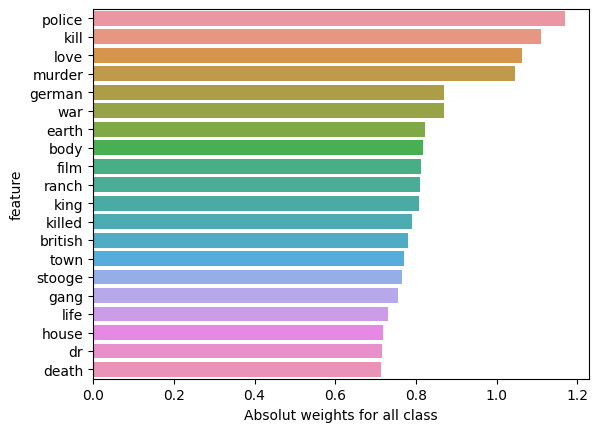

In [ ]:
plot_importance(log_reg_mll_reduced, vectorizer_lemm.get_feature_names_out(), mlb.classes_)

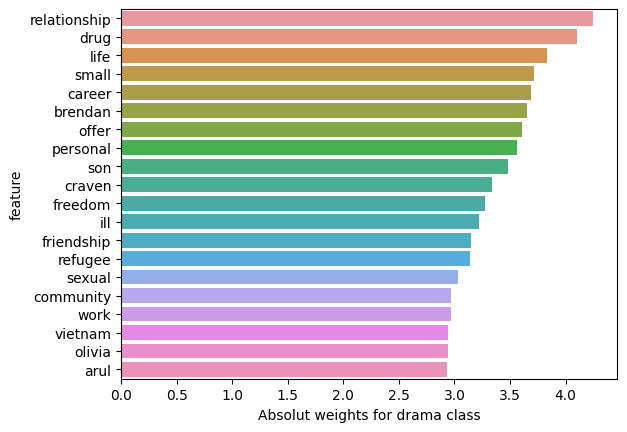

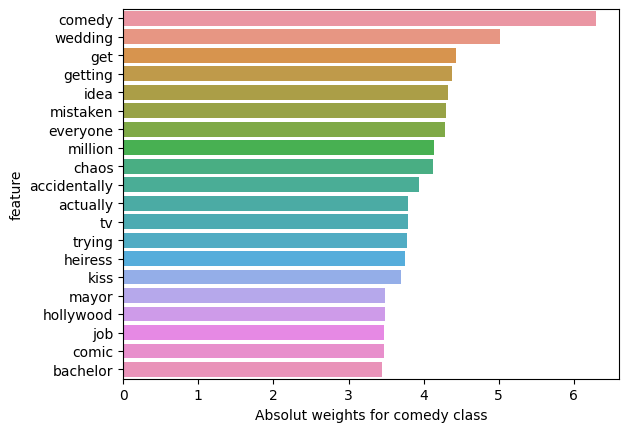

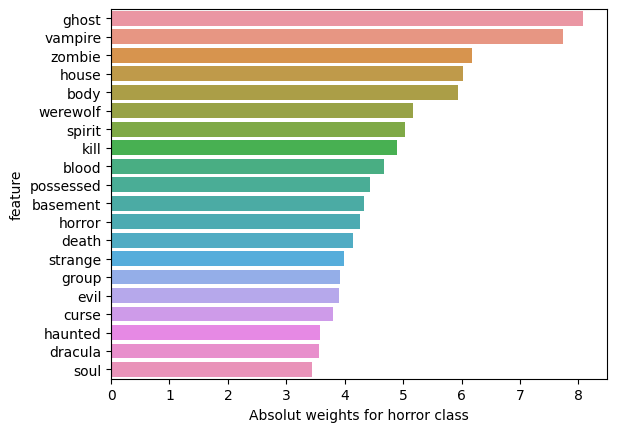

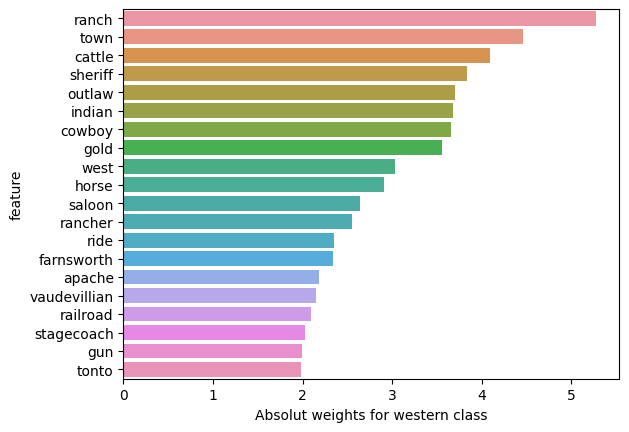

In [ ]:
for genre in ('drama', 'comedy', 'horror', 'western'):
    plot_importance(log_reg_mll_reduced, vectorizer_lemm.get_feature_names_out(), mlb.classes_, genre)
    plt.show()

I'd like to save such plots to all labels as it might be a useful information.

In [ ]:
for genre in mlb.classes_:
    plot_importance(log_reg_mll_reduced, vectorizer_lemm.get_feature_names_out(), mlb.classes_, genre)
    plt.savefig(f'../reports/figures/{genre}.png');

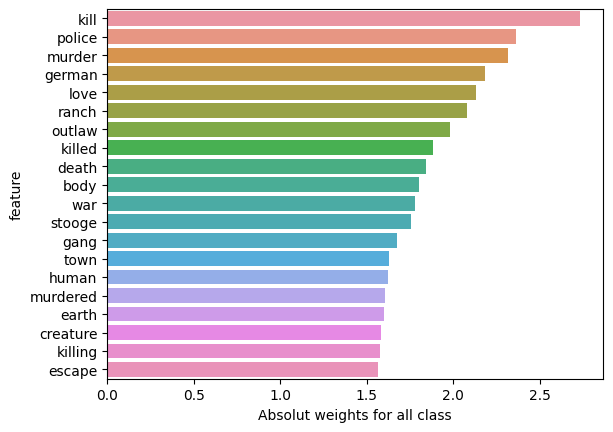

In [130]:
plot_importance(log_reg_mll_reduced, vectorizer_lemm.get_feature_names_out(), mlb.classes_)
plt.savefig(f'../reports/figures/average.png');

# Conclusions

From words importance plots I see that the most important words are pretty logical and predictable - for comedy we get words about family, for horror - vampires and ghosts, for western - ranch, sheriff and so on.

The best model after hyperparameters tuning appears to be chained logistic regression with jaccard score of 0.427 and full matcg accuracy of 
0.36. 

After that I've tried to train model only on instances with the most common and best predicted classes and achieved even better results - 0.431 full match accuracy and 0.496 jaccard score.

All in all, using multilabel approach hasn't improved full match accuracy but it does give more meaningful information and is better in terms of all avg's of f1 score.